### Imports

In [134]:
import numpy as np
from numpy.fft import fft2, ifft2
from PIL import Image
import PIL.ImageOps
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from math import sqrt

### Searching for pattern in the image with text

In [135]:
def get_array(file_path, original=False):
    """ Returns file contents as array
    
    :arg
        file_path: path of the file which content will be returned byt the function
        original:  if True, image is not modified; otherwise image is converted to greyscale
                   and colors are inverted (black -> white, white -> black)
        
    :returns
        numpy array with integers representing colors in greyscale
    """
    image = Image.open(file_path)
    
    if not original:
        image = image.convert("L")
        image = PIL.ImageOps.invert(image)

    return np.asarray(image)


def is_local_max(array, x, y):
    """ Checks if point is a local maximum
    
    :arg
        array: array contating points
        x, y:  coordinates of point in the array
        
    :returns
        boolean value telling whether the point is a local maximum or not
    """
    if x > 0:
        if array[x-1, y] > array[x, y]:
            return False
        if y > 0 and array[x-1, y-1] > array[x, y]:
            return False
        if y < array.shape[1] - 1 and array[x-1, y+1] > array[x, y]:
            return False
    
    if x < array.shape[0] - 1 :
        if array[x+1, y] > array[x, y]:
            return False
        if y > 0 and array[x+1, y-1] > array[x, y]:
            return False
        if y < array.shape[1] - 1 and array[x+1, y+1] > array[x, y]:
            return False
        
    if y > 0 and array[x, y-1] > array[x, y]:
        return False
    
    if y < array.shape[1] - 1 and array[x, y+1] > array[x,y]:
        return False
    
    return True


def get_occurrence_text(image, pattern, threshold):
    """ Returns all points where pattern matched to text in the image
    
    :arg
        image:     numpy array containg image
        pattern:   numpy image containing pattern to match
        threshold: number representing value which is minimal for classifying place on the
                   image as matched point
    
    :returns
        list of tuples: points where pattern is matched
    """
    occurrence = np.real(ifft2(fft2(image) * fft2(np.rot90(pattern, 2), image.shape)))
    
    highlighted_points = []
    
    for i in range(occurrence.shape[0]):
        for j in range(occurrence.shape[1]):
            if occurrence[i, j] > threshold:
                highlighted_points.append((j, i))

    return highlighted_points


def show_matchings(image, pattern, points):
    """ Shows image and matched parts of the image
    
    :arg
        image:   image as numpy array on which pattern was searched
        pattern: pattern as numpy array
        points:  matched points from which there will be made rectangles indicating matched areas
    """
    fig, ax = plt.subplots(1, 1, figsize=(15,10))

    ax.imshow(image, cmap='gray')
    
    width = pattern.shape[1] + 1
    height = pattern.shape[0] + 1
    
    for point in points:
        rect = patches.Rectangle((point[0] - width, point[1] - height), 
                                 width+2, height+2, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.show()

Number of found "e": 43


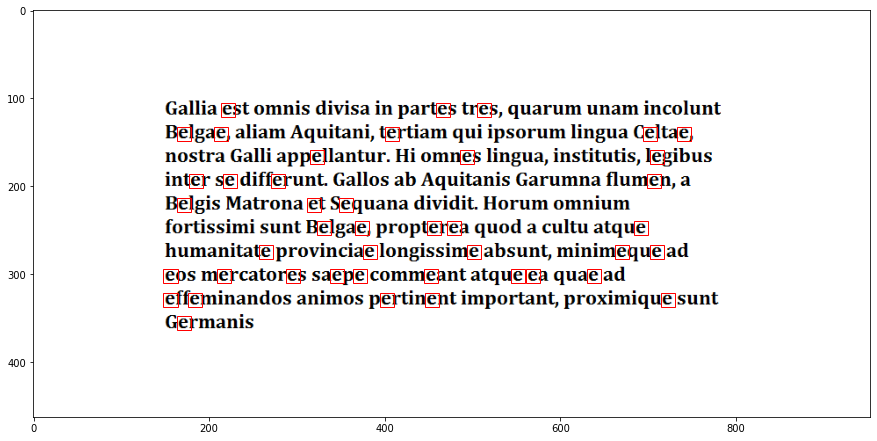

In [136]:
original_galia = get_array("image_analysis/galia.png", original=True)
galia = get_array("image_analysis/galia.png")
e = get_array("image_analysis/e.png")

points = get_occurrence_text(galia, e, threshold=3.5 * 10**6)

print(f"Number of found \"e\": {len(points)}")
show_matchings(original_galia, e, points)

#### Image of absolute values of Fourier coefficients

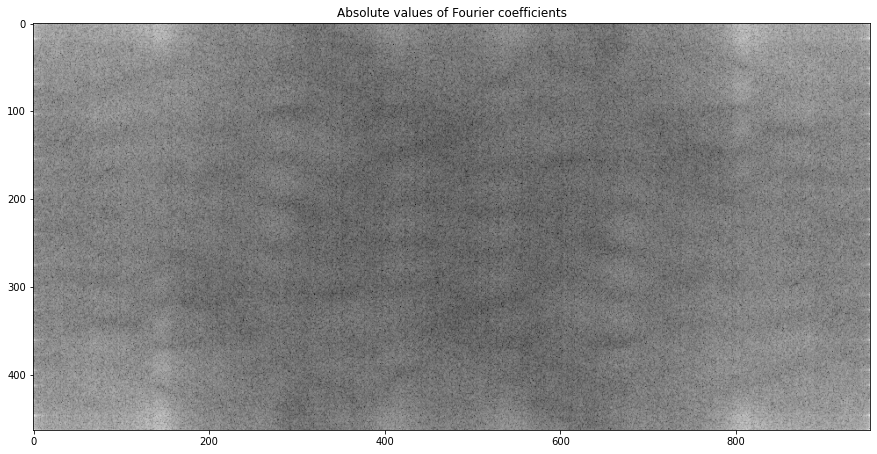

In [137]:
fig, ax = plt.subplots(1, 1, figsize=(15,10))
plt.imshow(np.log10(np.abs(fft2(galia))), cmap="gray")

ax.set_title("Absolute values of Fourier coefficients")

plt.show()

#### Image with phases of Fourier coefficients

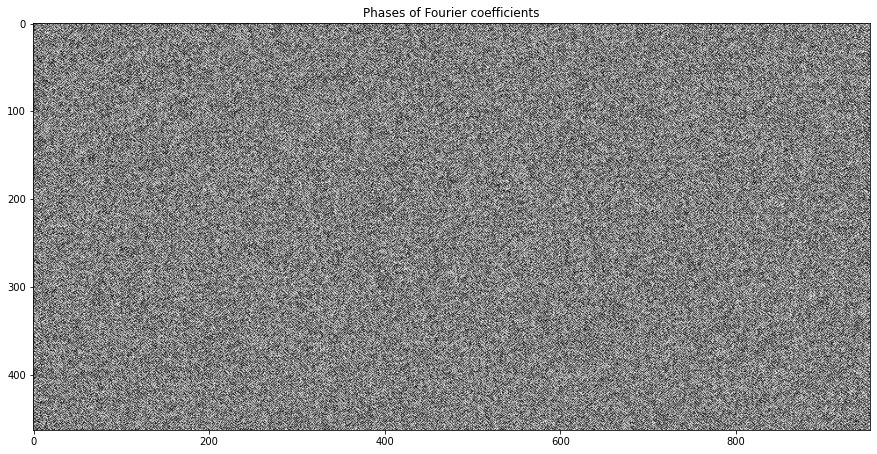

In [138]:
fig, ax = plt.subplots(1, 1, figsize=(15,10))
plt.imshow(np.angle(fft2(galia)), cmap="gray")

ax.set_title("Phases of Fourier coefficients")

plt.show()

### Searching for pattern in the image with school

In [139]:
def get_array_red(file_path):
    """ Gets array with red part of color of pixels in the image from file
    
    :arg
        file_path: path of the file with the image
        
    :returns
        numpy array containg integers representing red part of image color
    """
    image = Image.open(file_path)
    array = np.asarray(image)
    
    green_array = np.empty((array.shape[0], array.shape[1]))
    
    for i in range(array.shape[0]):
        for j in range(array.shape[1]):
            green_array[i, j] = array[i, j, 0]
            
    return green_array


def get_occurrence_school(image, pattern, threshold):
    """ Returns all points where pattern matched to image 
    
    :arg
        image:     numpy array containg image
        pattern:   numpy image containing pattern to match
        threshold: number representing value which is minimal for classifying place on the
                   image as matched point
    
    :returns
        - list of tuples: all local maxima where pattern is matched
        - list of integers: values representing how good the matching is in this point
          (size of both lists are equal)
    """
    occurrence = np.real(ifft2(fft2(image) * fft2(np.rot90(pattern, 2), image.shape)))
    
    highlighted_points = []
    local_maxima = []
    
    points_occurrences = []
    
    for i in range(occurrence.shape[0]):
        for j in range(occurrence.shape[1]):
            if occurrence[i, j] > threshold and is_local_max(occurrence, i, j):
                local_maxima.append((j, i))
                points_occurrences.append(occurrence[i, j])

    return local_maxima, points_occurrences


def erase_close(points, occurrences, distance):
    """ Erasing close values because it may suggest matching pattern many times to the same object
    
    :arg
        points:      list of matched local maxima
        occurrences: list with values representing how good the matching was in the point
                     (size of `points` and `occurrences` are equal)
        distance:    minimal distance between objects which is classifying points as far enough
        
    :retuns
        points which are far enough between each other
    """
    to_erase = []
    for i in range(len(points)):
        point_a = points[i]
        for j in range(len(points)):
            point_b = points[j]
            if point_a != point_b:
                if sqrt((point_a[0] - point_b[0])**2 + (point_a[1] - point_b[1])**2) < distance:
                    to_erase.append(point_a if occurrences[i] < occurrences[j] else point_b)
                    
    for point in to_erase:
        if point in points:
            points.remove(point)
            
    return points

Number of found fish: 91


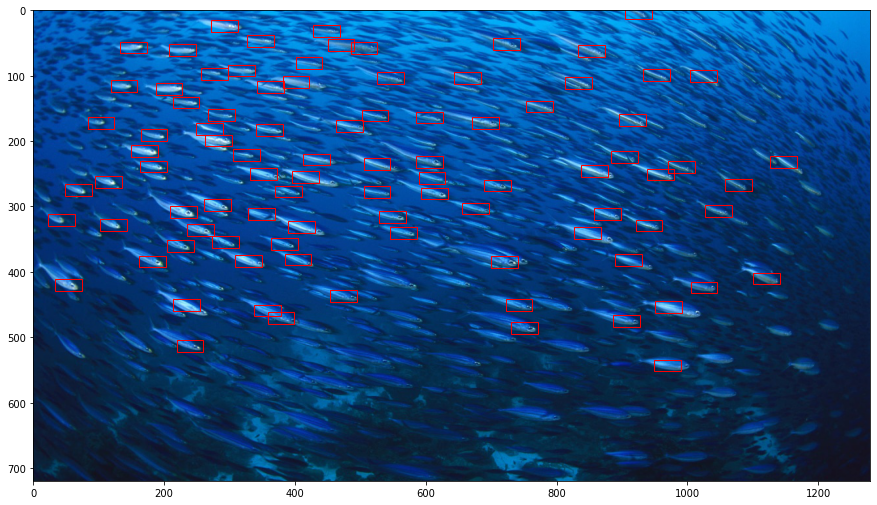

In [140]:
original_school = get_array("image_analysis/school.jpg", original=True)
school = get_array_red("image_analysis/school.jpg")
fish = get_array_red("image_analysis/fish.png")

maxima, occurrences = get_occurrence_school(school, fish, threshold=0.9 * 10**6)
points = erase_close(maxima, occurrences, 20)

print(f"Number of found fish: {len(points)}")
show_matchings(original_school, fish, points)